In [147]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from scipy.stats import skew

pd.options.display.max_columns = 500

Снова потренируемся в предсказании цен на недвижимость из [очередного датасета с каггла](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/)! В качестве основной метрики для валидации моделей будем использовать, как и ранее, `MSLE`.

P.S. в данной домашней работе при построении любых моделей, использующих недетерменированные элементы (как бутстрап), в алгоритме указывайте параметр `random_state = 1` для воспроизводимости результатов.

In [148]:
df = (
    pd.read_csv('train_houses_reg.csv')
    .drop('Id', axis=1)
)

df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,

In [149]:
### Разделим выборку на объекты-таргеты

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

### Логарифмируем таргет для будущей оптимизации
### MSLE через MSE

log_target = np.log1p(y)

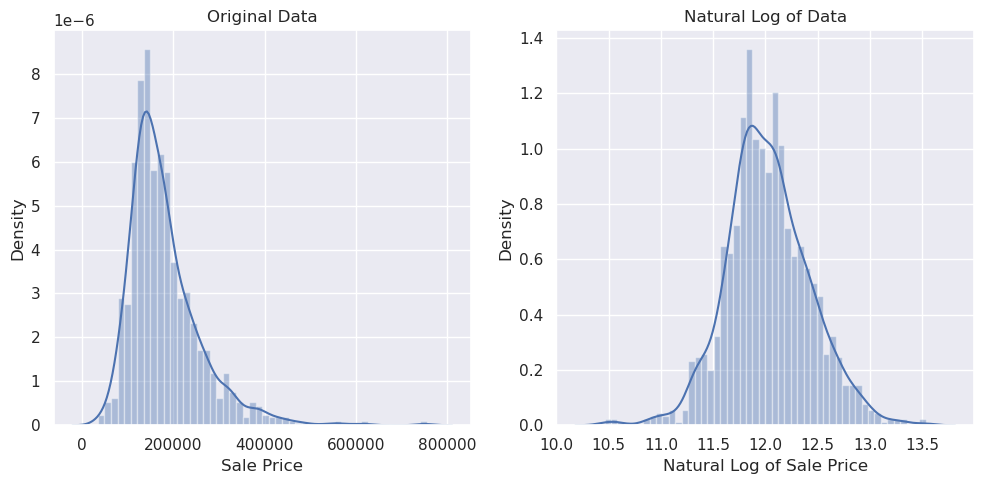

In [150]:
### Это позволяет получить нормальное распределение таргета
### Важно, например, для построения корректной
### С точки зрения статистических свойств
### Линейной модели.
### Хотя здесь мы будем строить ансамбли деревьев, 
### И это не особо интересно.

sns.set(rc={'figure.figsize':(15,10)})

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(y, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(log_target, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

### В начале поработаем с пропусками!

Если в какой-либо колонке оказывается достаточно много пропусков, обычно советуют от них избавляться. Мотивировано это тем, что в таких фичах мы можем наблюдать серьезный недостаток информативности, а заполнение пропусков может лишь внести лишнего шума в данные.

Избавьтесь от всех колонок, в которых пропусков оказывается больше 15%. (1б)

In [151]:
### Your code is here

# col_to_drop = []
# for i in zip(X.columns, X.isnull().sum() / X.shape[0]):
#     if i[1] > 0.15:
#         col_to_drop.append(i[0])
# print(col_to_drop)


is_over_85per = (X.isnull().sum() > X.shape[0]*0.15)
sparse_columns = is_over_85per.index[is_over_85per == True]
print(sparse_columns)

X = X.drop(sparse_columns, axis=1)

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


Вещественные колонки заполните медианным значением по фиче, а категориальные - самой популярной по колонке категорией. (2б)

Заметьте, что колонки `MoSold`, `YrSold`, `GarageYrBlt`, `YearBuilt`, `YearRemodAdd` хоть в таблице не являются типами `object`, вряд ли их справедливо использовать как вещественные. Обработайте их как категориальные.

In [152]:
### Your code is here
# categorical_not_obj = ["MoSold", "YrSold", "GarageYrBlt", "YearBuilt", "YearRemodAdd"]
# X[categorical_not_obj] = X[categorical_not_obj].astype(object)

# # Найдем категориальные колонки
# categorical_columns = X.select_dtypes([object]).columns

# # Найдем вещественные колонки
# numeric_columns = X.select_dtypes(exclude=[object]).columns

# X.fillna(X[numeric_columns].median())
# X.fillna(X[categorical_columns].mode().iloc[0]).astype(object)

# X.to_csv('HW_19.csv', sep=',', index=False)



In [153]:
X[categorical_columns].mode().iloc[0]


MSZoning              RL
Street              Pave
LotShape             Reg
LandContour          Lvl
Utilities         AllPub
LotConfig         Inside
LandSlope            Gtl
Neighborhood       NAmes
Condition1          Norm
Condition2          Norm
BldgType            1Fam
HouseStyle        1Story
YearBuilt           2006
YearRemodAdd        1950
RoofStyle          Gable
RoofMatl         CompShg
Exterior1st      VinylSd
Exterior2nd      VinylSd
MasVnrType          None
ExterQual             TA
ExterCond             TA
Foundation         PConc
BsmtQual              TA
BsmtCond              TA
BsmtExposure          No
BsmtFinType1         Unf
BsmtFinType2         Unf
Heating             GasA
HeatingQC             Ex
CentralAir             Y
Electrical         SBrkr
KitchenQual           TA
Functional           Typ
GarageType        Attchd
GarageYrBlt       2005.0
GarageFinish         Unf
GarageQual            TA
GarageCond            TA
PavedDrive             Y
MoSold                 6


In [154]:
# ### Your code is here
categorical_not_obj = ["MoSold", "YrSold", "GarageYrBlt", "YearBuilt", "YearRemodAdd"]
X[categorical_not_obj] = X[categorical_not_obj].astype(object)

categorical_columns=X.select_dtypes(include=['object']).columns.values
numeric_columns = X.select_dtypes(exclude=['object']).columns.values

X[categorical_columns] = X[categorical_columns].fillna(X[categorical_columns].mode().iloc[0]).astype(object)
X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].median())

X.to_csv('res_my.csv', sep=',', index=False)

In [155]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   object 
 17  YearRemodAdd   1460 non-null   object 
 18  RoofStyl

In [156]:
### Отложенная выборка

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    log_target, 
                                                    test_size=0.25, 
                                                    random_state=1)

Напишите трансформер, который будет делать следующее:

1. Масштабирование через StandardScaler для вещественных колонок
2. Кодирование через OneHotEncoder для категориальных, содержащих менее, чем 5 уникальных значений
3. Кодирование через TargetEncoder для всех остальных категориальных

Для этого советуем воспользоваться библиотекой `category_encoders` помимо `sklearn`.

А так же классом `ColumnTransformer` из `sklearn.compose`.

P.S. Напомним, что для деревьев процедура StandardScaling не обязательна (решающие деревья нечувствительны к масштабу). Тем не менее, это может сделать обучение модели менее тяжелым (хранить большие числа сложно для задач с большим количеством данных).

In [99]:
 X["YrSold"].nunique()

5

In [83]:
X.select_dtypes(exclude=['object']).columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [111]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### Your code is here

cols_for_ohe = ([col for col in categorical_columns if (X[col].nunique() < 5)])
cols_for_targ_enc = ([col for col in categorical_columns if X[col].nunique() >= 5])
numeric_columns = X.select_dtypes(exclude=['object']).columns.values


cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_te_idx = [list(X_train.columns).index(col) for col in cols_for_targ_enc]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_columns]


t = [('scaler',StandardScaler(), numeric_cols_idx),
     ('OHE', OneHotEncoder(), cols_for_ohe_idx),
     ('TargetEncoder', TargetEncoder(), cols_for_te_idx)]

col_transform = ColumnTransformer(transformers=t)

In [ ]:
for col in cols_for_targ_enc:
    print(list(X_train.columns).index(col))

In [105]:
col_transform.fit(X_train, y_train)

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCa...
                                 Index(['MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical',
       'Functional', 'GarageType', 'GarageYrBlt', 'GarageQual', 'GarageCond',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition'],
      dtype='object'))])

In [106]:
X_trans = col_transform.transform(X_train)

In [107]:
X_trans

array([[-0.87317294, -0.05084958,  1.36027394, ..., 12.05932193,
        11.99836226, 12.01480546],
       [ 0.31470676,  1.06099099, -0.8280218 , ..., 12.02344054,
        11.99836226, 12.01480546],
       [ 0.78985863, -0.34091205, -0.09858988, ..., 12.05932193,
        11.99836226, 12.01480546],
       ...,
       [ 0.31470676, -0.36590387, -0.09858988, ..., 12.05932193,
        11.99836226, 12.01480546],
       [ 2.4528902 , -0.8777441 , -0.09858988, ..., 12.03019756,
        11.99836226, 12.01480546],
       [-0.635597  ,  0.72802918, -2.28688562, ..., 12.03019756,
        11.99195755, 12.01480546]])

Посмотрите, как на наших данных справляется одно Решающее Дерево с дефолтными гиперпараметрами. Добавьте написанный ранее трансформер в модель. (1б)

In [108]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Your code is here
pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("decision_tree", 
                     DecisionTreeRegressor())])
pipe_dt.fit(X_train, y_train)


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr'...
       'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical',
       'Functional', 'GarageType', 'GarageYrBlt', 'GarageQual', 'GarageCond',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('decision_tree', DecisionTreeRegressor())])

In [109]:
from sklearn.metrics import mean_squared_error as mse
round(mse(y_test, pipe_dt.predict(X_test)), 3)

0.047

Справляется даже без контроля переобучения!

Посмотрим на перформанс Случайного Леса! Подберите параметры по отложенной выборке по данной сетке `param_grid`. Помните, что подбирать количество деревьев не супер обязательно, достаточно поставить их побольше. Что произошло с качеством модели по сравнению с одиноким деревом? (2б)

In [ ]:
RandomForestRegressor()

In [56]:
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

### Your code is here

from sklearn.ensemble import RandomForestRegressor

RandomForest_pipe = Pipeline([("column_transformer",
                               col_transform),
                  
                              ("random_forest", 
                               RandomForestRegressor(n_estimators=200))])

search = GridSearchCV(RandomForest_pipe, param_grid)


search.fit(X_train, y_train)

# (CV score=0.86352)
# 0.018691905969967455

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {round(mse(y_test, search.predict(X_test)), 3)}")

Best parameter (CV score=0.86207):
{'random_forest__max_depth': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2}
Качество лучшей модели на финальном тесте: 0.018


In [55]:

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {round(mse(y_test, search.predict(X_test)), 3)}")

Best parameter (CV score=0.86352):
{'random_forest__max_depth': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 5}
Качество лучшей модели на финальном тесте: 0.019


Попробуем теперь поэкспериментировать с бэггингами. 

Постройте бэггинги с 100 базовыми моделями (и остальными стандартными параметрами) над линейной регрессией, деревом и случайным лесом (бэггинг над бэггингом!). 

Какое качество у каждой модели на тесте?

Какой алгоритм получился лучше с точки зрения качества на тесте? (2б)

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

### Your code is here

pipe_rand_forest = Pipeline([("column_transform",
                  col_transform),
                  
                 ("Random_forest", 
                  RandomForestRegressor())])

bagging_forest = BaggingRegressor(base_estimator=pipe_rand_forest,
                            n_estimators=100, random_state=1)

bagging_forest.fit(X_train, y_train)



BaggingRegressor(base_estimator=Pipeline(steps=[('column_transform',
                                                 ColumnTransformer(transformers=[('scaler',
                                                                                  StandardScaler(),
                                                                                  [0,
                                                                                   2,
                                                                                   14,
                                                                                   15,
                                                                                   23,
                                                                                   31,
                                                                                   33,
                                                                                   34,
                                                                                   35,
                                                                                   40,
                                                                                   41,
                                                                                   42,
                                                                                   43,
                                                                                   44,
                                                                                   45,
                                                                                   46,
                                                                                   47,
                                                                                   48,
                                                                                   49,
                                                                                   51,
                                                                                   53,
                                                                                   57,
                                                                                   58,
                                                                                   62,
                                                                                   63,
                                                                                   64,
                                                                                   65,
                                                                                   66,
                                                                                   67,
                                                                                   68]),
                                                                                 ('OHE',
                                                                                  OneHotEncoder(),
                                                                                  [3,
                                                                                   4,
                                                                                   5,
                                                                                   6,
                                                                                   8,
                                                                                   22,
                                                                                   24,
                                                                                   27,
                                                                                   28,
                                                                                   29,
                                                                            

In [113]:
mse(y_test, bagging_forest.predict(X_test))

0.01912491170005029

In [114]:
pipe_linreg = Pipeline([("column_transformer",
                  col_transform),
                  
                 ("LinReg", 
                  LinearRegression())])

bagging_linreg = BaggingRegressor(base_estimator=pipe_linreg,
                            n_estimators=100, random_state=1)

bagging_linreg.fit(X_train, y_train)



BaggingRegressor(base_estimator=Pipeline(steps=[('column_transformer',
                                                 ColumnTransformer(transformers=[('scaler',
                                                                                  StandardScaler(),
                                                                                  [0,
                                                                                   2,
                                                                                   14,
                                                                                   15,
                                                                                   23,
                                                                                   31,
                                                                                   33,
                                                                                   34,
                                                                                   35,
                                                                                   40,
                                                                                   41,
                                                                                   42,
                                                                                   43,
                                                                                   44,
                                                                                   45,
                                                                                   46,
                                                                                   47,
                                                                                   48,
                                                                                   49,
                                                                                   51,
                                                                                   53,
                                                                                   57,
                                                                                   58,
                                                                                   62,
                                                                                   63,
                                                                                   64,
                                                                                   65,
                                                                                   66,
                                                                                   67,
                                                                                   68]),
                                                                                 ('OHE',
                                                                                  OneHotEncoder(),
                                                                                  [3,
                                                                                   4,
                                                                                   5,
                                                                                   6,
                                                                                   8,
                                                                                   22,
                                                                                   24,
                                                                                   27,
                                                                                   28,
                                                                                   29,
                                                                          

In [115]:
mse(y_test, bagging_linreg.predict(X_test))

7.191234074392836e+20

In [116]:
pipe_tree = Pipeline([("column_transformer",
                  col_transform),
                  
                 ("Tree", 
                  DecisionTreeRegressor())])

bagging_tree = BaggingRegressor(base_estimator=pipe_tree,
                            n_estimators=100, random_state=1)

bagging_tree.fit(X_train, y_train)



BaggingRegressor(base_estimator=Pipeline(steps=[('column_transformer',
                                                 ColumnTransformer(transformers=[('scaler',
                                                                                  StandardScaler(),
                                                                                  [0,
                                                                                   2,
                                                                                   14,
                                                                                   15,
                                                                                   23,
                                                                                   31,
                                                                                   33,
                                                                                   34,
                                                                                   35,
                                                                                   40,
                                                                                   41,
                                                                                   42,
                                                                                   43,
                                                                                   44,
                                                                                   45,
                                                                                   46,
                                                                                   47,
                                                                                   48,
                                                                                   49,
                                                                                   51,
                                                                                   53,
                                                                                   57,
                                                                                   58,
                                                                                   62,
                                                                                   63,
                                                                                   64,
                                                                                   65,
                                                                                   66,
                                                                                   67,
                                                                                   68]),
                                                                                 ('OHE',
                                                                                  OneHotEncoder(),
                                                                                  [3,
                                                                                   4,
                                                                                   5,
                                                                                   6,
                                                                                   8,
                                                                                   22,
                                                                                   24,
                                                                                   27,
                                                                                   28,
                                                                                   29,
                                                                          

In [117]:
mse(y_test, bagging_tree.predict(X_test))

0.018178864910380038

Улучшил ли бэггинг над Лесом качество по сравнению с одним Лесом с точки зрения как качества на тесте, так и на трейне. Как это можно объяснить? Как думаете, много ли смысла в использовании бэггинга над линейными моделями? Выбрали бы вы в данной ситуации именно их в качестве базовых?

### Добавим новые фичи!

Создайте следующие четыре новые вещественные фичи:

1. Отношения площади 1 этажа к общей площади (колонки 1stFlrSF и GrLivArea, в %)
2. Отношение Площади завершенного фундамента первого типа к общей площади фундамента (колонки BsmtFinSF1 и TotalBsmtSF, в %)
3. Возраст дома (между YearBuilt и YrSold)
4. Общая площадь самого дома и фундамента/цоколя (1stFlrSF + 2ndFlrSF + TotalBsmtSF)

Обучите заново Случайный лес и найдите лучшие гиперпараметры на старой сетке.

Улучшили ли качество модели новые фичи? (4б)

In [146]:
X

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,ratio_1_on_square,ratio_base1_on_total,age_house,square,ratio_1_on_square,ratio_base1_on_total,age_house,square
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,50.058480,82.476636,5,2566,50.058480,82.476636,5,2566
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,100.000000,77.496038,31,2524,100.000000,77.496038,31,2524
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,51.511758,52.826087,7,2706,51.511758,52.826087,7,2706
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,55.969715,28.571429,91,2473,55.969715,28.571429,91,2473
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,52.092812,57.205240,8,3343,52.092812,57.205240,8,3343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,57.862781,0.000000,8,2600,57.862781,0.000000,8,2600
1456,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,100.000000,51.232166,32,3615,100.000000,51.232166,32,3615
1457,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,50.769231,23.871528,69,3492,50.769231

In [128]:

print(ratio_1_on_square.name)

ratio_1_on_square


In [157]:
def func_ratio_base1_on_total(X):
    return (X['BsmtFinSF1'] / X['TotalBsmtSF'] * 100).fillna(0)

In [158]:
### Your code is here

ratio_1_on_square = X['1stFlrSF'] / X['GrLivArea'] *100
ratio_1_on_square.name = 'ratio_1_on_square'
ratio_base1_on_total = func_ratio_base1_on_total(X)
ratio_base1_on_total.name = 'ratio_base1_on_total'
age_house = X['YrSold'] - X['YearBuilt']
age_house.name = 'age_house'
square = X['1stFlrSF'] + X['2ndFlrSF'] + X['TotalBsmtSF']
square.name = 'square'


X_ = pd.concat([X, ratio_1_on_square, ratio_base1_on_total, age_house, square], axis=1)

In [159]:
X_["ratio_base1_on_total"]

0       82.476636
1       77.496038
2       52.826087
3       28.571429
4       57.205240
          ...    
1455     0.000000
1456    51.232166
1457    23.871528
1458     4.545455
1459    66.082803
Name: ratio_base1_on_total, Length: 1460, dtype: float64

In [162]:
X = X_

In [163]:

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    log_target, 
                                                    test_size=0.25, 
                                                    random_state=1)

In [164]:
cols_for_ohe = ([col for col in categorical_columns if (X[col].nunique() < 5)])
cols_for_targ_enc = ([col for col in categorical_columns if X[col].nunique() >= 5])
numeric_columns = X.select_dtypes(exclude=['object']).columns.values


cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_te_idx = [list(X_train.columns).index(col) for col in cols_for_targ_enc]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_columns]


t = [('scaler',StandardScaler(), numeric_cols_idx),
     ('OHE', OneHotEncoder(), cols_for_ohe_idx),
     ('TargetEncoder', TargetEncoder(), cols_for_te_idx)]

col_transform = ColumnTransformer(transformers=t)

In [165]:
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

### Your code is here

from sklearn.ensemble import RandomForestRegressor

RandomForest_pipe = Pipeline([("column_transformer",
                               col_transform),
                  
                              ("random_forest", 
                               RandomForestRegressor())])

search = GridSearchCV(RandomForest_pipe, param_grid, scoring='neg_mean_squared_error')


search.fit(X_train, y_train)

# (CV score=0.86352)
# 0.018691905969967455


GridSearchCV(estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         [0, 2,
                                                                          14,
                                                                          15,
                                                                          23,
                                                                          31,
                                                                          33,
                                                                          34,
                                                                          35,
                                                                          40,
                                                                          41,
                                                                          42,
                                                                          43,
                                                                          44,
                                                                          45,
                                                                          46,
                                                                          47,
                                                                          48,
                                                                          49,
                                                                          51,
                                                                          53,
                                                                          57,
                                                                          58,
                                                                          62,
                                                                          63,
                                                                          64,
                                                                          65,
                                                                          66,
                                                                          67,
                                                                          68, ...]),
                                                                        ('OHE',
                                                                         OneHotEncoder(),
                                                                         [3, 4,
                                                                          5, 6,
                                                                          8, 22,
                                                                          24,
                                                                          27,
                                                                          28,
                                                                          29,
                                                                          38,
                                                                          50,
                                                                          56,
                                                                          61]),
                                                                        ('TargetEncoder',
                                                                         TargetEncoder(),
                                                                         [1, 7,
                                                                          9, 10,
                                                                          11,
                                     

In [166]:

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {round(mse(y_test, search.predict(X_test)), 3)}")

Best parameter (CV score=-0.02134):
{'random_forest__max_depth': 15, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2}
Качество лучшей модели на финальном тесте: 0.018
